# Data analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# INDICATOR = ['quintilAlfabetizacao','quintilRenda']
# INDICATOR_PRED = ['quintilAlfabetizacaoPred','quintilRendaPred']
# INDICATOR_TITLE= ['Literacy', 'Income']
# FOLDER = ['literacy','income']
INDICATOR = ['quintilRenda']
INDICATOR_PRED = ['quintilRendaPred']
INDICATOR_TITLE= ['Income']
FOLDER = ['income']

## Distribution of socioeconomic indicators per census sectors

### Number of street images used for training

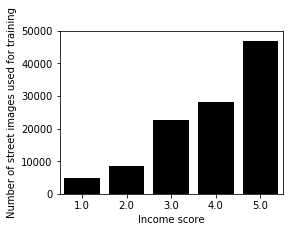

In [34]:
for s in range(0,len(INDICATOR)):
    df = pd.concat([pd.read_csv(f'{FOLDER[s]}/folds/fold-{FOLD}.csv', 
                            usecols=['filename','latitude','longitude','setor','fold',INDICATOR[s]])
                for FOLD in range(0,5)], ignore_index=True)  
    df['photos'] = df['filename'].notna().astype(int)        
    ds = pd.DataFrame(df.groupby(INDICATOR[s])['photos'].sum().reset_index())
    df_new = ds.rename(columns={INDICATOR[s]: INDICATOR_TITLE[s]})
    #display(df_new)
    
    plt.figure(figsize=(4,3))    
    ax= sns.barplot(x= df_new[INDICATOR_TITLE[s]], y=df_new['photos'], color = 'black')
    #plt.title(INDICATOR_TITLE[s])    
    
    ax.set(xlabel=INDICATOR_TITLE[s] + ' score', ylabel='Number of street images used for training')
    ax.set(ylim=(0, 50000))
    plt.show()

In [36]:
display(df_new)

display(df_new['photos'].sum())

,Income,photos
0,1.0,4828
1,2.0,8372
2,3.0,22688
3,4.0,28196
4,5.0,46740


110824

### Number of street images for prediction

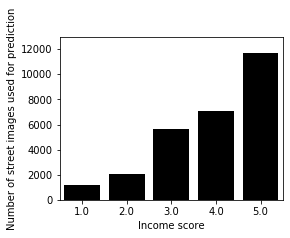

In [32]:
for s in range(0,len(INDICATOR)):
    df = pd.concat([pd.read_csv(f'{FOLDER[s]}/folds/pred-{FOLD}.csv') for FOLD in range(0,5)], ignore_index=True)  
    df['photos'] = df['setor'].notna().astype(int)        
    ds = pd.DataFrame(df.groupby(INDICATOR[s])['photos'].sum().reset_index())
    df_new = ds.rename(columns={INDICATOR[s]: INDICATOR_TITLE[s]})
    #display(df_new)
    
    plt.figure(figsize=(4,3))    
    ax= sns.barplot(x= df_new[INDICATOR_TITLE[s]], y=df_new['photos'], color = 'black')
    #plt.title(INDICATOR_TITLE[s])    
    
    ax.set(xlabel=INDICATOR_TITLE[s] + ' score', ylabel='Number of street images used for prediction')
    ax.set(ylim=(0, 13000))
    plt.show()

In [33]:
display(df_new)

display(df_new['photos'].sum())

,Income,photos
0,1.0,1207
1,2.0,2093
2,3.0,5672
3,4.0,7049
4,5.0,11685


27706

### Distribution of street images per scores

Hypothesis testing: Google images are from high scores

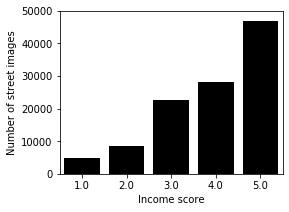

In [24]:
for s in range(0,len(INDICATOR)):
    geo = pd.read_csv('geo.csv',
                      usecols=['city','direction','filename','latitude','longitude','setor']) #this is not necessary, geo.csv is on all folders
    idh = pd.read_csv('IDHMs/IDHM_ValeRibeira.csv')

    df = pd.merge(geo, idh, left_on='setor', right_on='Cod_setor', how='left')
    df['photos'] = df['filename'].notna().astype(int)        
    ds = pd.DataFrame(df.groupby(INDICATOR[s])['photos'].sum().reset_index())
    df_new = ds.rename(columns={INDICATOR[s]: INDICATOR_TITLE[s]})
    #display(df_new)
    
    plt.figure(figsize=(4,3))    
    ax= sns.barplot(x= df_new[INDICATOR_TITLE[s]], y=df_new['photos'], color = 'black')
    #plt.title(INDICATOR_TITLE[s])    
    
    ax.set(xlabel=INDICATOR_TITLE[s] + ' score', ylabel='Number of street images')
    ax.set(ylim=(0, 50000))
    plt.show()

In [25]:
display(df_new)

display(df_new['photos'].sum())

,Income,photos
0,1.0,4828
1,2.0,8372
2,3.0,22688
3,4.0,28196
4,5.0,46740


110824

## Street view images

In [24]:
from PIL import Image
from urllib.parse import urlencode
import random
import requests
from tqdm import tqdm 

import numpy as np
np.random.seed(286571) #seed random generator for reproduciblity

In [7]:
def get_image(pano_id, direction):
    y_ = []
    for y in range(2):
        params = {
            "cb_client": "maps_sv.tactile",
            "authuser": 0,
            "hl": "en",
            "gl": "br",
            "x": direction // 90,
            "y": y,
            "zoom": 2,
            "nbt": None,
            "fover": 0,
            "output": "tile",
            "panoid": pano_id,
        }
        url = f"https://geo{np.random.randint(0, 3)}.ggpht.com/cbk?{urlencode(params)}"
        img = np.asarray(Image.open(requests.get(url, stream=True).raw))
        y_.append(img[256:, :, :] if y == 0 else img[:256, :, :])
    return np.concatenate(y_)

def plot_image(score, w,h):
    _, axs = plt.subplots(w, h, figsize=(5,5))
    plt.suptitle(f'Samples for {INDICATOR_TITLE[s]} with score = {score}')      

    sample = ds[ds[INDICATOR[s]] == score].sample(w*h)
    for i in tqdm(range(0,w * h), leave=False):            
        row = sample.iloc[i]        
        axs[i%w][i//h].imshow(get_image(row['pano_id'], row['direction']))

In [ ]:
for s in range(0,len(INDICATOR)):
    df = pd.read_csv('geo_fold.csv') 
    idh = pd.read_csv('IDHMs/IDHM_ValeRibeira.csv')
    ds = pd.merge(df, idh, left_on='setor', right_on='Cod_setor', how='inner')
    
    plot_image(score=1, w=2,h=2)
    plot_image(score=3, w=2,h=2)
    plot_image(score=5, w=2,h=2)         
         

### Saving images samples

In [25]:
for s in range(0,len(INDICATOR)):
    df = pd.read_csv('geo_fold.csv')
    idh = pd.read_csv('IDHMs/IDHM_ValeRibeira.csv', usecols=['Cod_setor', INDICATOR[s]]) 
    #df = pd.read_csv('geo.csv')
    ds = pd.merge(df, idh, left_on='setor', right_on='Cod_setor', how='inner')


    for score in range(1, 5+1):            
        num_samples=6
        rand_samples =np.random.randint(200, size=num_samples) #4 samples
        sample = ds[ds[INDICATOR[s]] == score].sample(200)
        for c in range(0, num_samples):
            row = sample.iloc[rand_samples[c]]
            while True:
                try:                    
                    fig, axs = plt.subplots(1, 1, figsize=(10,10))
                    plt.imshow(get_image(row['pano_id'], row['direction']))
                    #plt.suptitle(f'Score {score}')
                    axs.axes.get_xaxis().set_visible(False)
                    axs.axes.get_yaxis().set_visible(False)
                    axs.set_aspect('equal')
                    break
                except OSError:
                    continue
                    
            plt.savefig(f'{FOLDER[s]}/score_images/{INDICATOR_TITLE[s]}-score-{score}-sample-{c+4}.png')
            plt.close()


# Prediction performance

## Socioeconomic indicators

In [37]:
for s in range(0,len(INDICATOR)):
    data = {f'fold {i}':{} for i in range(0,5)} 
    for i in range(0,5):#    
        for error in range(2): #'±0', '±1', '±2'            
            pred_fold = pd.read_csv(f'{FOLDER[s]}/folds/pred-{i}.csv')
            data[f'fold {i}'][error] = ((pred_fold[INDICATOR[s]]-pred_fold[INDICATOR_PRED[s]]).abs() <= error).astype(int).mean()
    r = pd.DataFrame(data)    
    r.index = ['±0', '±1']
    r.index.name = 'Margin'   
    print(INDICATOR_TITLE[s] + ' score')
    display(r)

Income score


,fold 0,fold 1,fold 2,fold 3,fold 4
Margin,,,,,
±0,0.540690,0.558460,0.551391,0.547795,0.539804
±1,0.841531,0.828153,0.840242,0.827543,0.840784


## Confusion matrix

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from IPython.display import display

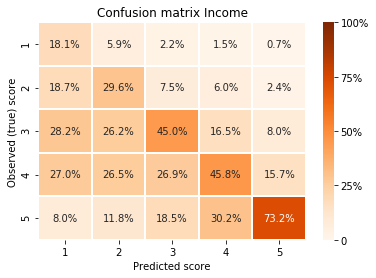

In [32]:
for s in range(0,len(INDICATOR)):
    df = pd.concat([pd.read_csv(f'{FOLDER[s]}/folds/pred-{FOLD}.csv') for FOLD in range(0,5)], ignore_index=True)
    
    cf = confusion_matrix(df[INDICATOR[s]], df[INDICATOR_PRED[s]])

    plt.figure(figsize=(6,4))
    ax=sns.heatmap((cf.T/cf.sum(axis=1)), xticklabels=range(1,5+1),yticklabels=range(1,5+1),
                annot=True, 
                fmt='.1%', cmap='Oranges',
                vmin=0, vmax=1,
               linewidths=1)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, .5, .75, 1])
    cbar.set_ticklabels(['0', '25%', '50%', '75%', '100%'])
    plt.title("Confusion matrix "+ INDICATOR_TITLE[s])
    plt.xlabel('Predicted score')
    plt.ylabel('Observed (true) score')    
    plt.savefig(fname=f'plots/confmatrix-{INDICATOR_TITLE[s]}.pdf', dpi=300, facecolor='w', edgecolor='w')
    plt.savefig(fname=f'plots/confmatrix-{INDICATOR_TITLE[s]}.png', dpi=300, facecolor='w', edgecolor='w')


In [ ]:
cf.sum(axis=1).sum(axis=0)*4

## Vale do Ribeira geomap prediction

In [27]:
import geopandas as gpd
import pandas as pd
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

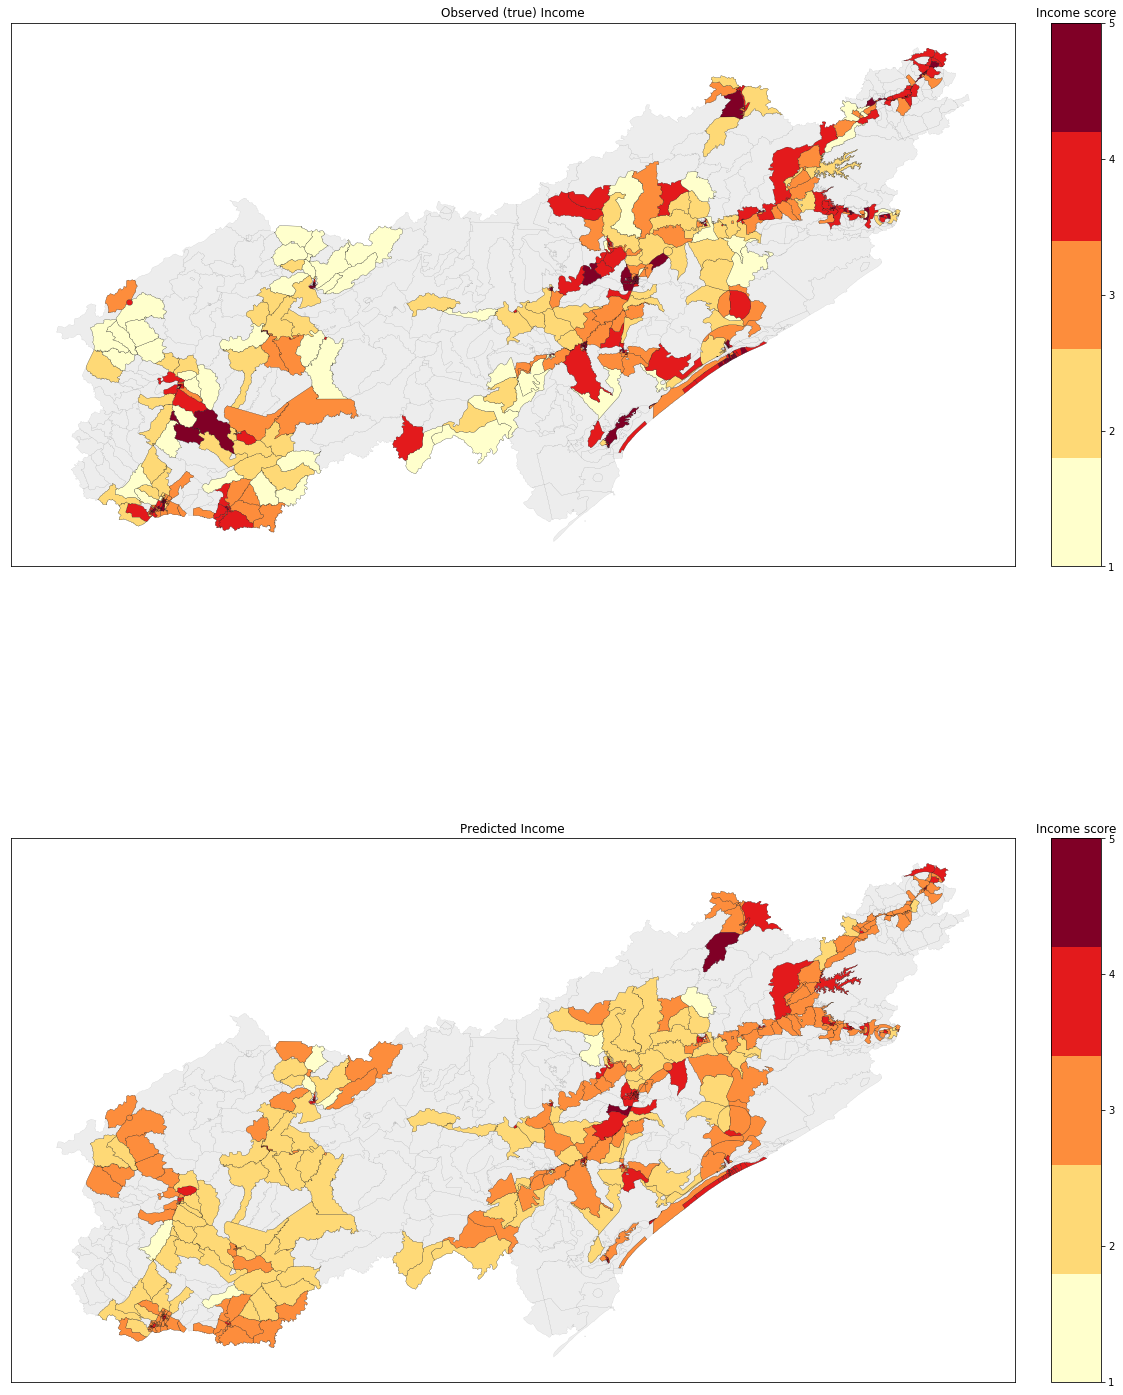

In [29]:
geo = gpd.read_file('raw_data/shapefiles/vale_ribeira.dbf')
df = pd.concat([pd.read_csv(f'{FOLDER[s]}/folds/pred-{FOLD}.csv') for FOLD in range(0,5)], ignore_index=True)
df = pd.merge(df, geo, left_on='setor', right_on='CD_GEOCODI', how='left')

real = df.groupby('setor', as_index=False, group_keys=False).agg(
    {'geometry': lambda x: x.tolist()[0], INDICATOR[s]: lambda x: int(x.mean())})

g_real=gpd.GeoDataFrame(real)#Convert Pandas DataFrame to GeoPandas DataFrame    

pred = df.groupby('setor', as_index=False, group_keys=False).agg(
{'geometry': lambda x: x.tolist()[0], INDICATOR_PRED[s]: lambda x: int(x.mean())})
g_pred=gpd.GeoDataFrame(pred)

# -- configuring fancy plots params --- 
missing_kwds={"color": "lightgrey",
              "label": "Missing values",
             "linewidth":0.5}
#"edgecolor": "black",#"hatch": "...", "hatch":"///"

cmap = plt.cm.get_cmap('YlOrRd', 5)    # 5 discrete colors
    
fig, axs = plt.subplots(2, 1, figsize=(20*5,5*5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

def plot_colorbar(axes):    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=5))
    sm._A = []
    divider = make_axes_locatable(axes=axes)
    cax = divider.append_axes("right", size="5%", pad=0.5)
    cbar = fig.colorbar(sm, cax=cax,  ticks=[1,2,3,4,5])
    cbar.ax.set_title('Income score')

    
#---- 1st subplot ---- 
axs[0].set_title(f'Observed (true) {INDICATOR_TITLE[s]}')     

# Introduce some missing values:
#g_real.loc[np.random.choice(g_real.index, 120), INDICATOR[s]] = np.nan
geo.plot(color= 'lightgray',alpha=0.4, edgecolor='black', ax=axs[0], linewidth=0.1) #contourn
g_real.plot(column=INDICATOR[s], ax=axs[0], cmap=cmap,linewidth=0.2,edgecolor='black', missing_kwds=missing_kwds)#color-fill

#axs[0].set_axis_off()
axs[0].axes.get_xaxis().set_visible(False)
axs[0].axes.get_yaxis().set_visible(False)
axs[0].set_aspect('equal')
plot_colorbar(axs[0])


#---- 2nd subplot ----     
axs[1].set_title(f'Predicted {INDICATOR_TITLE[s]}')#RdBu

# Introduce some missing values:
#g_pred.loc[np.random.choice(g_pred.index, 120), INDICATOR_PRED[s]] = np.nan

geo.plot(color= 'lightgray',alpha=0.4, edgecolor='black', ax=axs[1], linewidth=0.1)#contourn
g_pred.plot(column=INDICATOR_PRED[s], ax=axs[1],cmap=cmap,linewidth=0.2,edgecolor='black', missing_kwds=missing_kwds)#color-fill
#geo.boundary.plot
#axs[1].set_axis_off()
axs[1].axes.get_xaxis().set_visible(False)
axs[1].axes.get_yaxis().set_visible(False)
axs[1].set_aspect('equal')
plot_colorbar(axs[1])


plt.savefig(fname='plots/map_prediction.pdf', dpi=300, facecolor='w', edgecolor='w')
plt.savefig(fname='plots/map_prediction.png', dpi=300, facecolor='w', edgecolor='w')
plt.show() 


In [ ]:
pred